<a href="https://colab.research.google.com/github/moissinac/DMWikipedia/blob/main/notebookwikipedia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importer les librairies

In [5]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline


Charger le dataset obtenu avec https://densitydesign.github.io/strumentalia-seealsology/ en utilisant la liste d'url de wikipedia suivante
https://fr.wikipedia.org/wiki/Musée_Carnavalet
https://fr.wikipedia.org/wiki/Palais_Galliera,_musée_de_la_Mode_de_la_ville_de_Paris
https://fr.wikipedia.org/wiki/Crypte_archéologique_de_lîle_de_la_Cité
https://fr.wikipedia.org/wiki/Musée_des_arts_décoratifs_de_Paris
https://fr.wikipedia.org/wiki/Paris_Musées
https://fr.wikipedia.org/wiki/Maison_de_Balzac
https://fr.wikipedia.org/wiki/Musée_Bourdelle
https://fr.wikipedia.org/wiki/Petit_Palais
https://fr.wikipedia.org/wiki/Musée_Zadkine
https://fr.wikipedia.org/wiki/Musée_du_Général_Leclerc_de_Hauteclocque_et_de_la_Libération_de_Paris_-_musée_Jean-Moulin
https://fr.wikipedia.org/wiki/Musée_Cernuschi
https://fr.wikipedia.org/wiki/Mus%C3%A9e_de_la_Vie_romantique
https://fr.wikipedia.org/wiki/Mus%C3%A9e_de_la_Vie_romantique
https://fr.wikipedia.org/wiki/Mus%C3%A9e_Cognacq-Jay

en enlevant tout ce qui concerne les catégories dans les filtres par défaut

In [15]:
df = pd.read_csv("/content/drive/MyDrive/DataMusée/Données/parismusees_niveau5_data.tsv", sep = "\t")
#df = pd.read_csv("sample_data/parismusees_niveau5_data.tsv", sep = "\t")
df.head()

,source,target,depth
0,musée cognacq-jay,ernest cognacq,1
1,musée cognacq-jay,marie-louise jaÿ,1
2,musée cognacq-jay,hôtel de donon,1
3,musée cognacq-jay,musée ernest-cognacq,1
4,musée de la vie romantique,ary scheffer,1


Construire le graphe

In [7]:
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())
len(G)

4188

Définir comment faire les random walks

In [8]:
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk


Tester un random walk

In [9]:
get_randomwalk('musée de la vie romantique', 10)

['musée de la vie romantique',
 'peinture romantique',
 'peinture néo-classique',
 'jean-auguste-dominique ingres']

Calculer 5 walks de profondeur 10 pour chaque entité du graphe

In [10]:
# get list of all nodes from the graph
all_nodes = list(G.nodes())

random_walks = []
for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))
        
# count of sequences
len(random_walks)

100%|██████████| 4188/4188 [00:00<00:00, 9197.78it/s]


20940

Prépare word2vec

In [11]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

Calcule le modèle skip-gram

In [12]:
# train skip-gram (word2vec) model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(1880449, 1988420)

Trouver les entités les plus similaires de musée de la vie romantique

In [13]:
model.similar_by_word('musée de la vie romantique')

[('ary scheffer', 0.9481973648071289),
 ('peinture romantique', 0.9469882249832153),
 ('jean-auguste-dominique ingres', 0.8812362551689148),
 ('maurice de saxe (1696-1750)', 0.8786525726318359),
 ('marie-aurore de saxe', 0.8751312494277954),
 ('peinture française du xixe siècle', 0.8660030364990234),
 ('sculpture française du xixe siècle', 0.8597906827926636),
 ('raphaël mengs', 0.859208345413208),
 ('style empire', 0.8575707674026489),
 ('romantisme français', 0.8536772131919861)]

Affichage 2D de la projection 2D des vecteurs d'un ensemble d'entité

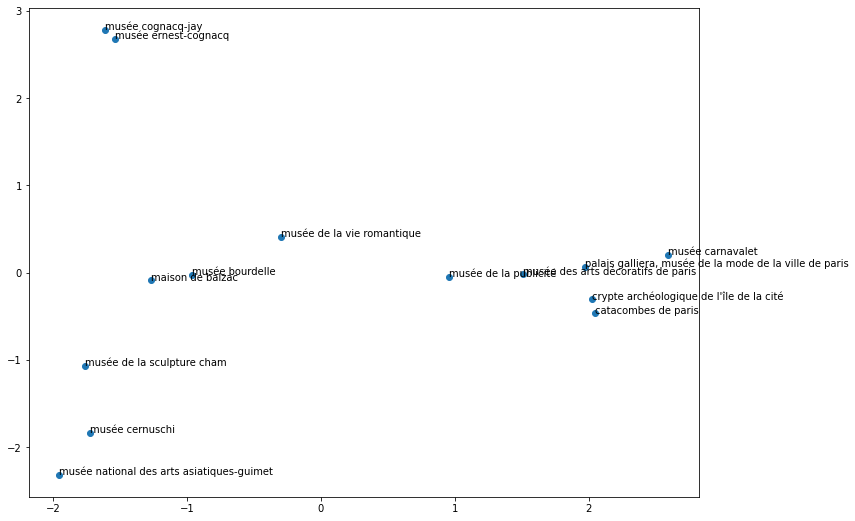

In [14]:
terms = ['musée carnavalet', 'musée cernuschi', 'musée de la vie romantique',
         'musée cognacq-jay', 'musée national des arts asiatiques-guimet',
         'palais galliera, musée de la mode de la ville de paris',
         "crypte archéologique de l'île de la cité",
         'catacombes de paris', 'maison de balzac',
         'musée des arts décoratifs de paris', 'musée de la publicité',
         'musée bourdelle', 'musée de la sculpture cham',
         'musée ernest-cognacq']
def plot_nodes(word_list):
    X = model[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()

plot_nodes(terms)